## Customer Segmentation RFM

## **Content:**

I will be using RFM (Recency, Frequency, Monetary) for clustering customer data. RFM is a method used to segment customers based on their purchasing behavior, which helps in tailoring effective marketing strategies. Recency indicates how recently a customer made a purchase, Frequency tells us how often they make purchases, and Monetary represents the total amount they have spent. Analyzing these dimensions allows businesses to categorize customers into groups like loyal customers, big spenders, or those at risk of churn.

Using RFM segmentation, I aim to understand the value of different customer groups, predict future behaviors, and create targeted marketing campaigns. This dataset, comprising transactions from a UK-based online retail company selling unique gifts, spans from 01/12/2010 to 09/12/2011. Many customers are wholesalers, making it ideal for RFM analysis to uncover insights that can enhance customer retention and maximize revenue. To determine the optimal number of clusters for segmentation, I will utilize the elbow method with K-means clustering.

For more details on the dataset, you can visit [Kaggle](https://www.kaggle.com/datasets/carrie1/ecommerce-data).


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.preprocessing import MinMaxScaler
from math import pi


In [3]:
# Reading the CSV file with 'latin1' encoding
df = pd.read_csv('Data/data.csv', encoding='latin1')

# Displaying the last few rows of the DataFrame
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Data Cleaning

In [5]:
copied_df = df.copy()

In [6]:
copied_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df2 = copied_df.dropna()


In [8]:
df2.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
# Filter rows containing any NaN values
rows_with_nan = df2[df2.isna().any(axis=1)]

print("Rows containing NaN values:")
print(rows_with_nan)

Rows containing NaN values:
Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []


In [10]:
df2.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [12]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [13]:
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])

In [14]:
# Convert CustomerID column to integers
df2['CustomerID'] = df2['CustomerID'].astype(int)

# Convert CustomerID column to object type
df2['CustomerID'] = df2['CustomerID'].astype('object')

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [16]:
df2.describe()

,Quantity,InvoiceDate,UnitPrice
count,406829.000000,406829,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471
min,-80995.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-06 15:02:00,1.250000
50%,5.000000,2011-07-31 11:48:00,1.950000
75%,12.000000,2011-10-20 13:06:00,3.750000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,248.693370,NaN,69.315162


In [17]:
# Extract rows where 'quantity' column values are less than -1
extracted_rows = df2[df2['Quantity'] < -1]

# Drop those rows from the main DataFrame
df2 = df2[df2['Quantity'] > -1]

print("Extracted rows:")
print(extracted_rows)

print("\nUpdated DataFrame:")
print(df2)

Extracted rows:
       InvoiceNo StockCode                        Description  Quantity  \
235      C536391     22556     PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984   PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983   PACK OF 12 BLUE PAISLEY TISSUES        -24   
238      C536391     21980  PACK OF 12 RED RETROSPOT TISSUES        -24   
239      C536391     21484        CHICK GREY HOT WATER BOTTLE       -12   
...          ...       ...                                ...       ...   
540422   C581484     23843        PAPER CRAFT , LITTLE BIRDIE    -80995   
540448   C581490     22178    VICTORIAN GLASS HANGING T-LIGHT       -12   
540449   C581490     23144    ZINC T-LIGHT HOLDER STARS SMALL       -11   
541715   C581568     21258         VICTORIAN SEWING BOX LARGE        -5   
541717   C581569     20979      36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice CustomerID         Country  
235    2010-12-0

In [18]:
df2.describe()

,Quantity,InvoiceDate,UnitPrice
count,397924.000000,397924,397924.000000
mean,13.021823,2011-07-10 23:43:36.912475648,3.116174
min,1.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-07 11:12:00,1.250000
50%,6.000000,2011-07-31 14:39:00,1.950000
75%,12.000000,2011-10-20 14:33:00,3.750000
max,80995.000000,2011-12-09 12:50:00,8142.750000
std,180.420210,NaN,22.096788


In [19]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## Exploratory Data Analysis

#### Countries Distribution

In [20]:
df2['Country'].value_counts()

Country
United Kingdom          354345
Germany                   9042
France                    8342
EIRE                      7238
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45


#### Region Distribution

In [21]:
# Mapping dictionary
country_to_region = {
    'United Kingdom': 'Europe',
    'Germany': 'Europe',
    'France': 'Europe',
    'EIRE': 'Europe',
    'Spain': 'Europe',
    'Netherlands': 'Europe',
    'Belgium': 'Europe',
    'Switzerland': 'Europe',
    'Portugal': 'Europe',
    'Australia': 'Oceania',
    'Norway': 'Europe',
    'Italy': 'Europe',
    'Channel Islands': 'Europe',
    'Finland': 'Europe',
    'Cyprus': 'Europe',
    'Sweden': 'Europe',
    'Austria': 'Europe',
    'Denmark': 'Europe',
    'Poland': 'Europe',
    'Japan': 'Asia',
    'Israel': 'Asia',
    'Unspecified': 'Not specified',
    'Singapore': 'Asia',
    'Iceland': 'Europe',
    'USA': 'North America',
    'Canada': 'North America',
    'Greece': 'Europe',
    'Malta': 'Europe',
    'United Arab Emirates': 'Middle East',
    'European Community': 'Europe',
    'RSA': 'Africa',
    'Lebanon': 'Asia',
    'Lithuania': 'Europe',
    'Brazil': 'South America',
    'Czech Republic': 'Europe',
    'Bahrain': 'Middle East',
    'Saudi Arabia': 'Middle East'
}

# Create a new column 'Region' based on the mapping
df2['Region'] = df2['Country'].map(country_to_region)

# Display the DataFrame with the new column

df2


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Region
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,Europe
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,Europe
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,Europe
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,Europe
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,Europe
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,Europe


In [22]:
region_counts = df2['Region'].value_counts()
region_counts

Region
Europe           395145
Oceania            1185
Asia                836
North America       330
Not specified       244
Middle East          94
Africa               58
South America        32
Name: count, dtype: int64

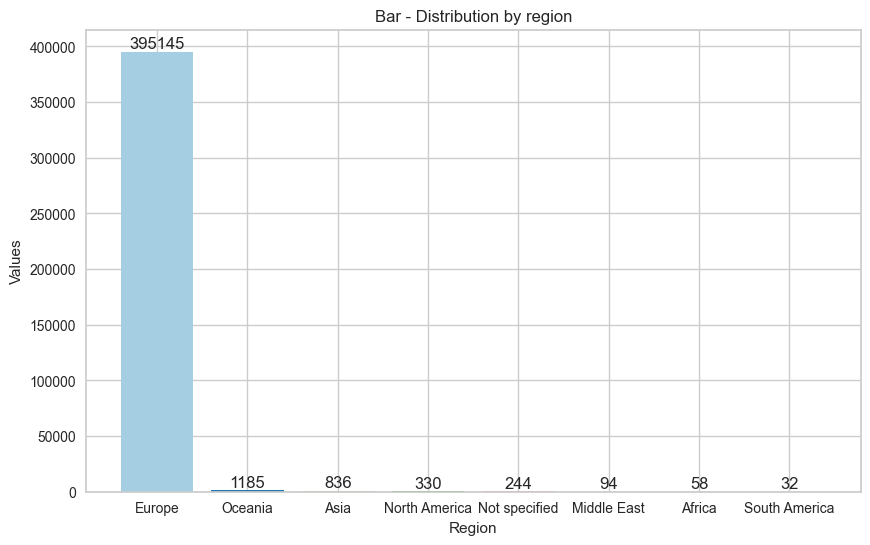

In [23]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(region_counts.index, region_counts.values, color=plt.cm.Paired(np.arange(len(region_counts))))

# Adding labels and title
plt.xlabel('Region')
plt.ylabel('Values')
plt.title('Bar - Distribution by region')

# Adding count values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', va='bottom')


# Save the image
plt.savefig("Bar - Distribution by region.png", dpi=300, bbox_inches="tight")

plt.show()

The bar chart shows the distribution of counts of transactions by region, with Europe having an exceptionally high value of 395,145 units, far surpassing all other regions. Oceania follows distantly with 1,185 units, and Asia with 836 units. North America, the "Not specified" category, and the Middle East have even lower values of 330, 244, and 94 units respectively. Africa and South America exhibit minimal values of 58 and 32 units. The dramatic disparity, especially with Europe's dominance, highlights a significant concentration of values in this region, while other regions contribute negligibly. The use of colors helps to clearly distinguish the different regions.

In [24]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Region
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,Europe
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,Europe
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe


#### Total sales amount per transaction

In [25]:
df2['Sales_amount'] = df2['Quantity'] * df2['UnitPrice']

df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Region,Sales_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,Europe,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,Europe,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34


#### Bar plot of total Sales Amount by country

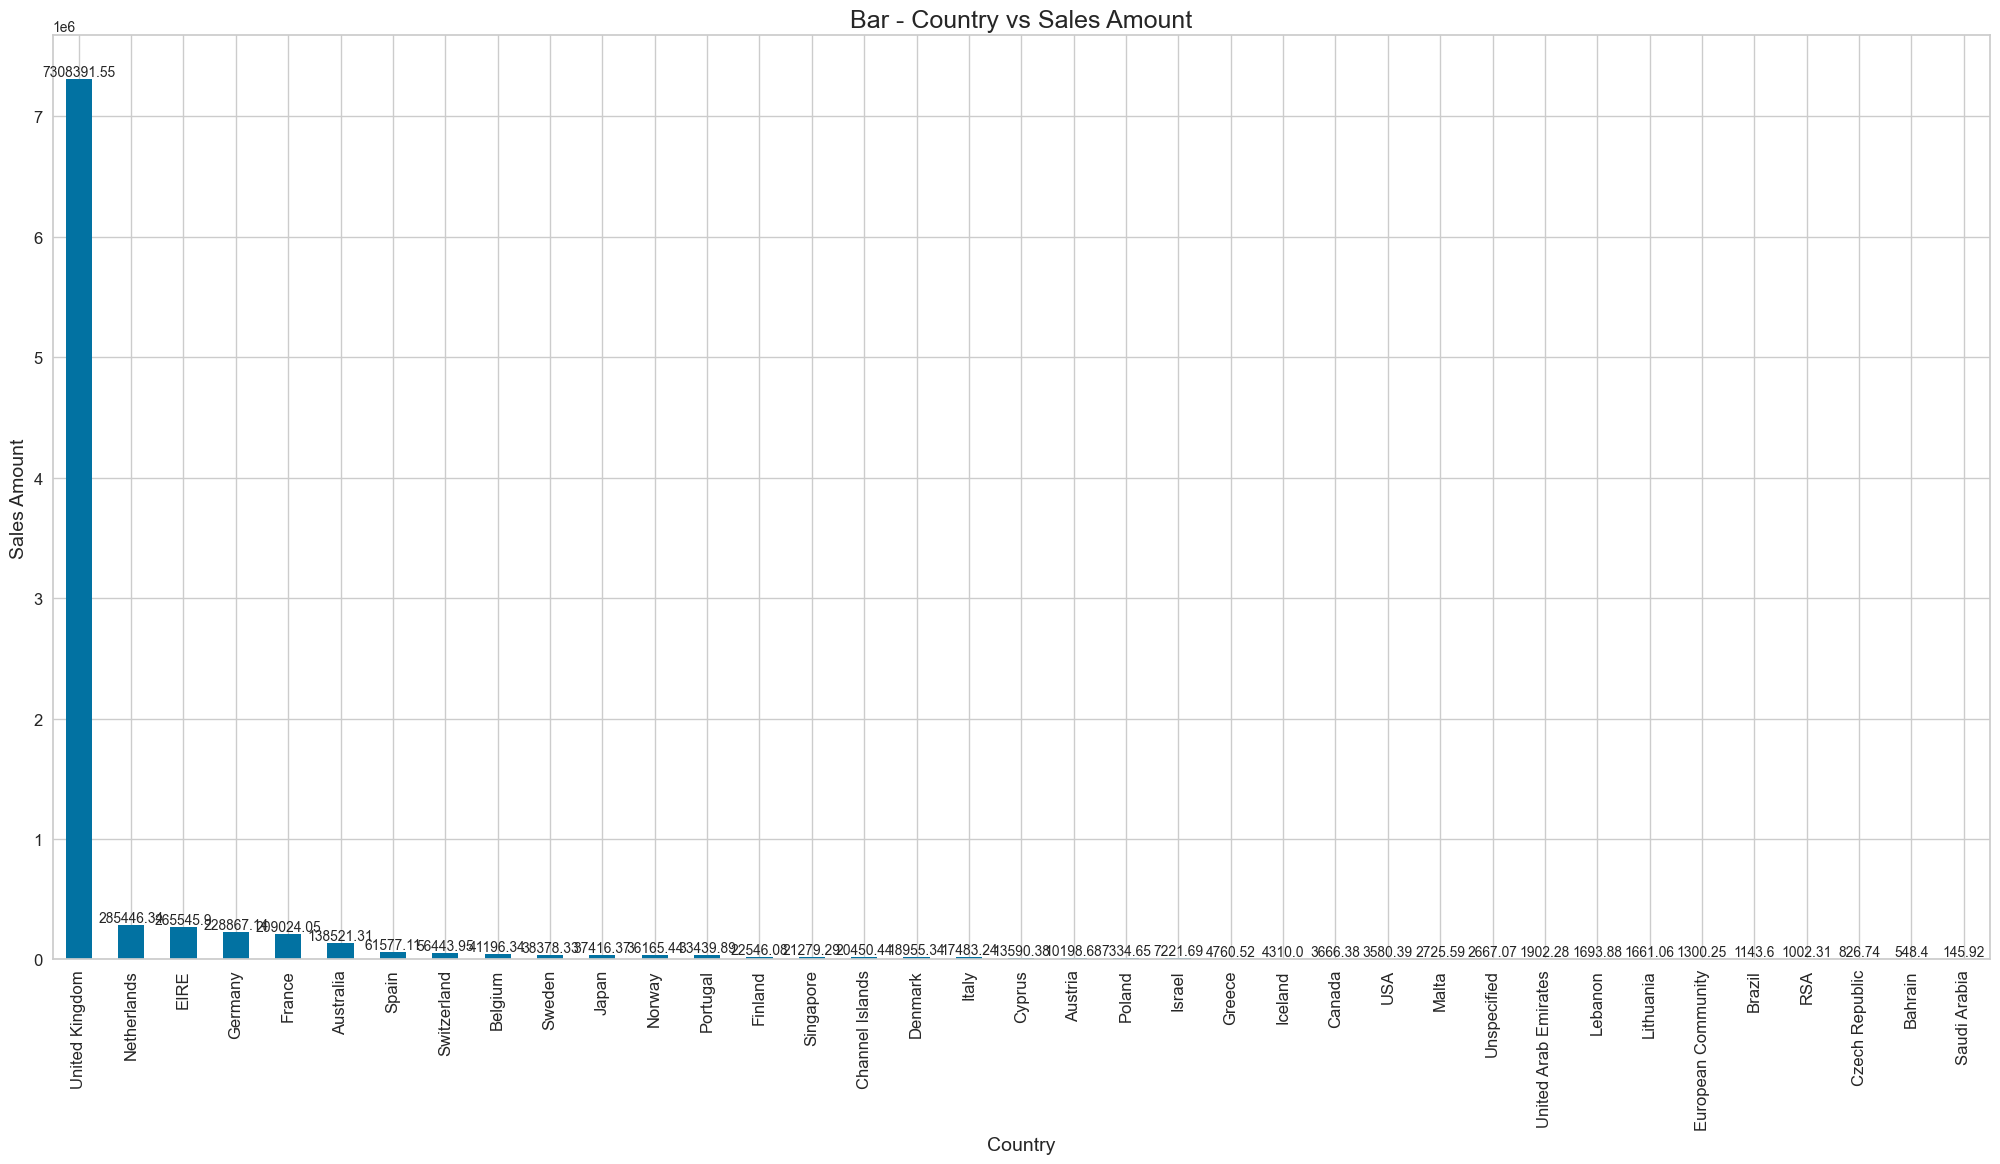

In [26]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(25, 12))

# Plotting the bar chart
bars = df2.groupby('Country')['Sales_amount'].sum().sort_values(ascending=False).plot.bar(ax=ax, fontsize=12)

# Adding labels and title
ax.set_title("Bar - Country vs Sales Amount", fontsize=18)
ax.set_xlabel("Country", fontsize=14)
ax.set_ylabel("Sales Amount", fontsize=14)

# Annotate each bar with its value
for bar in bars.patches:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 100, round(yval, 2), ha='center', va='bottom', fontsize=10)

# Save the image
plt.savefig("Bar - Country vs Sales Amount.png", dpi=300, bbox_inches="tight")

plt.show()

The bar graph illustrates the sales amounts for various countries, highlighting a significant disparity in sales distribution. The United Kingdom dominates with an overwhelming sales amount of 7,308,391.55, far exceeding any other country. The next highest sales amounts are for the Netherlands, EIRE, and Germany, each with sales between approximately 200,000 and 300,000. All other countries have considerably lower sales, with most not surpassing 100,000. This pronounced concentration of sales in the United Kingdom suggests a strong market presence or customer base there, while other countries contribute minimally to the overall sales. The graph underscores the United Kingdom's critical role in the sales landscape, with other countries playing a relatively minor role.

#### Summary of Total Sales Amount by each region

In [27]:
# Group merged_df by age
regions = df2.groupby('Region')
 
# Initialize a dictionary to store peak amounts by age
max_amount_by_region = {}
min_amount_by_region = {}
total_amount_by_region = {}
 
# Iterate over age groups to find peak amount for each age
for region, group_data in regions:
    max_amount = group_data['Sales_amount'].max()
    min_amount = group_data['Sales_amount'].min()
    total_amount = round(group_data['Sales_amount'].sum(),2)
    max_amount_by_region[region] = max_amount
    min_amount_by_region[region] = min_amount
    total_amount_by_region[region] = total_amount
 
# Convert the dictionary to a DataFrame for easier analysis (optional)
max_amount_by_region_df = pd.DataFrame(list(max_amount_by_region.items()), columns=['Region', 'Max_Amount'])
min_amount_by_region_df = pd.DataFrame(list(min_amount_by_region.items()), columns=['Region', 'Min_Amount'])
total_amount_by_region_df = pd.DataFrame(list(total_amount_by_region.items()), columns=['Region', 'Total_Amount'])
 
# Print or visualize the result
#print(max_amount_by_age_df min_amount_by_age_df)

min_max = max_amount_by_region_df.merge(min_amount_by_region_df, on='Region')
min_max_total = min_max.merge(total_amount_by_region_df, on='Region')
min_max_total

,Region,Max_Amount,Min_Amount,Total_Amount
0,Africa,38.25,0.00,1002.31
1,Asia,3949.32,0.29,67611.23
2,Europe,168469.60,0.00,8690619.01
3,Middle East,153.00,3.48,2596.60
4,North America,550.94,1.25,7246.77
5,Not specified,69.36,0.19,2667.07
6,Oceania,1718.40,0.00,138521.31
7,South America,175.20,15.00,1143.60


#### Plots of Min, Max, and Total Sales Amount by each region

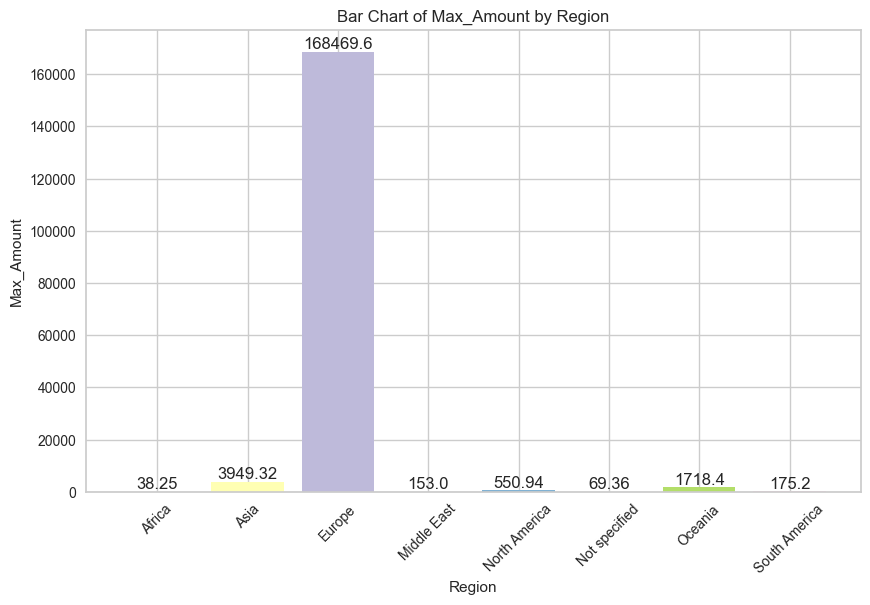

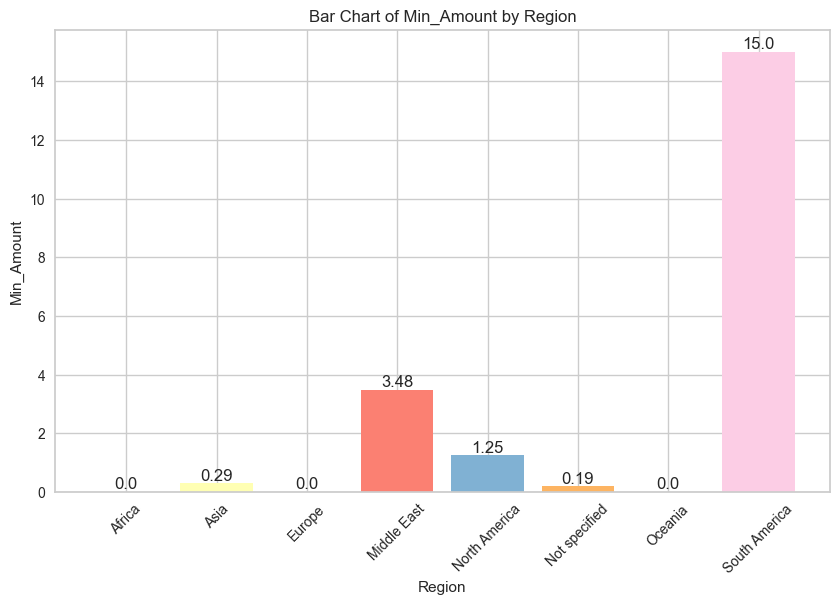

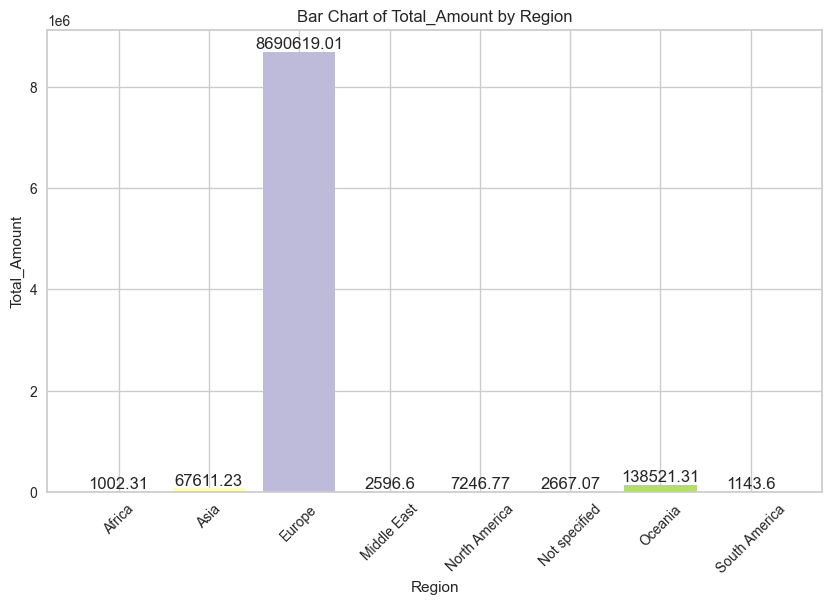

In [28]:
# Function to plot bar charts
def plot_bar_chart(column_name):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(min_max_total['Region'], min_max_total[column_name], color=sns.color_palette("Set3"))
    plt.xlabel('Region')
    plt.ylabel(column_name)
    plt.title(f'Bar Chart of {column_name} by Region')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    # Annotate each bar with its value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')
    
    
    
    # Save the image
    plt.savefig("Bar - Min Max Total(region).png", dpi=300, bbox_inches="tight")
    
    
    plt.show()

# Plotting bar charts for each column
plot_bar_chart('Max_Amount')
plot_bar_chart('Min_Amount')
plot_bar_chart('Total_Amount')



**Maximum sales amount by region:**

The bar chart presents the maximum sales amount by region, revealing a stark contrast between Europe and the other regions. Europe, with a maximum sales amount of 168,469.6, vastly outstrips all other regions. Asia and Oceania follow but with much smaller figures of 3,949.32 and 1,718.4, respectively. The remaining regions—Africa, Middle East, North America, "Not specified," and South America—show negligible maximum sales amounts, all under 1,000. This chart underscores Europe's dominance in maximum sales transactions, indicating either a higher number of large sales or more significant single transactions compared to other regions. The substantial disparity highlights the critical importance of Europe in the overall sales performance.


**Minimum amount by region:**

The bar chart displays the minimum amount by region, with South America leading significantly at 15.0 units. The Middle East follows with 3.48 units, and North America with 1.25 units. Asia and the "Not specified" category show minimal values of 0.29 and 0.19 units respectively, while Africa, Europe, and Oceania report 0.0 units. The substantial value for South America suggests a notably higher minimum amount in this region compared to others. The zero values in Africa, Europe, and Oceania indicate no recorded minimum amounts for these regions in the dataset. The color differentiation helps in visualizing the regional differences effectively.


**Total amount by region:**

The bar chart illustrates the total amount by region, with Europe showing an overwhelmingly high total amount of 8690619.01 units, significantly outpacing all other regions. Oceania follows with 138521.31 units, and Asia with 67611.23 units. North America, the Middle East, and the "Not specified" category have relatively lower totals of 7246.77, 2596.6, and 2667.07 units respectively. Africa and South America exhibit minimal totals of 1002.31 and 1143.6 units. The stark contrast, particularly with Europe's dominance, suggests a concentration of high total amounts in this region, while other regions contribute relatively smaller sums. The colors aid in distinguishing between the various regions effectively.

#### Movement of Sales Amount by All regions over time

In [29]:
# Extract month and year from 'InvoiceDate' and convert to string for plotting
df2['YearMonth'] = df2['InvoiceDate'].dt.strftime('%b\'%Y')  # Format like Jan'2011

# Group by 'Region' and 'YearMonth', summing 'Sales_amount'
region_monthly_sales = df2.groupby(['Region', 'YearMonth'])['Sales_amount'].sum().reset_index()

# Get unique regions
regions = region_monthly_sales['Region'].unique()

# Extract only 'YearMonth' values to ensure proper ordering
year_months = region_monthly_sales['YearMonth'].unique()

# Sort 'YearMonth' values chronologically (Dec'2010, Jan'2011, Feb'2011, etc.)
sorted_months = sorted(year_months, key=lambda x: pd.to_datetime(x, format='%b\'%Y'))

# Create a mapping dictionary to ensure proper order in Plotly
month_order = {month: idx for idx, month in enumerate(sorted_months)}

# Assign a numerical index to each 'YearMonth' based on the sorted order
region_monthly_sales['MonthIndex'] = region_monthly_sales['YearMonth'].map(month_order)

# Sort data by 'MonthIndex' to ensure it's plotted in ascending order
region_monthly_sales = region_monthly_sales.sort_values(by='MonthIndex')

# Plot using Plotly
fig = go.Figure()

# Colors for different regions
colors = ['green', 'blue', 'red', 'orange', 'purple', 'brown', 'pink', 'gray']

for idx, region in enumerate(regions):
    # Filter data for the current region
    data = region_monthly_sales[region_monthly_sales['Region'] == region]
    
    # Plot each region with a different color
    fig.add_trace(go.Scatter(x=data['YearMonth'], y=data['Sales_amount'],
                             mode='lines+markers',
                             name=region,
                             line=dict(color=colors[idx % len(colors)], width=2),  # Line color
                             marker=dict(color=colors[idx % len(colors)], size=8, line=dict(color='black', width=1)),  # Marker color with black borders
                             ))

# Customize layout
fig.update_layout(title='Sales Trend for All Regions',
                  title_font_color='white',  # Title font color
                  title_x=0.5,  # Title center alignment
                  xaxis_title='Month',
                  yaxis_title='Sales Amount',
                  xaxis=dict(tickangle=-45, categoryorder='array', categoryarray=sorted_months),  # Ensure x-axis is in correct order
                  plot_bgcolor='black',  # Black background
                  paper_bgcolor='black',  # Black background
                  font=dict(color='white'),  # White text color
                  legend=dict(font=dict(color='white')),  # White legend text color
                  )


# Save the image
plt.savefig("Sales Trend for All Regions.png", dpi=300, bbox_inches="tight")

fig.show()

<Figure size 800x550 with 0 Axes>

The graph shows the sales trends across different regions from December 2010 to December 2011. Europe (in red) significantly outperforms all other regions, with a relatively consistent but slightly fluctuating trend and noticeable peaks in May 2011 and November 2011. The sales amounts for Africa, Asia, Middle East, North America, Oceania, and South America are minimal and appear almost flat, indicating negligible sales compared to Europe. This highlights that Europe is the dominant region in terms of sales, while the other regions contribute very little to the overall sales volume. The legend effectively distinguishes the different regions by color, aiding in the interpretation of the data.

#### Movement of Sales Amount by each regions over time

In [30]:
# Extract month and year from 'InvoiceDate' and convert to string for plotting
df2['YearMonth'] = df2['InvoiceDate'].dt.strftime('%b\'%Y')  # Format like Jan'2011

# Group by 'Region' and 'YearMonth', summing 'Sales_amount'
region_monthly_sales = df2.groupby(['Region', 'YearMonth'])['Sales_amount'].sum().reset_index()

# Get unique regions
regions = region_monthly_sales['Region'].unique()

# Creating interactive plots for each region
for region in regions:
    # Filter data for the current region
    data = region_monthly_sales[region_monthly_sales['Region'] == region]
    
    # Extract only 'YearMonth' values to ensure proper ordering
    year_months = data['YearMonth'].unique()
    
    # Sort 'YearMonth' values chronologically (Dec'2010, Jan'2011, Feb'2011, etc.)
    sorted_months = sorted(year_months, key=lambda x: pd.to_datetime(x, format='%b\'%Y'))
    
    # Create a mapping dictionary to ensure proper order in Plotly
    month_order = {month: idx for idx, month in enumerate(sorted_months)}
    
    # Assign a numerical index to each 'YearMonth' based on the sorted order
    data['MonthIndex'] = data['YearMonth'].map(month_order)
    
    # Sort data by 'MonthIndex' to ensure it's plotted in ascending order
    data = data.sort_values(by='MonthIndex')
    
    # Plot using Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data['YearMonth'], y=data['Sales_amount'],
                             mode='lines+markers',
                             name=region,
                             line=dict(color='green', width=2),  # Green line
                             marker=dict(color='green', size=8, line=dict(color='black', width=1)),  # Green markers with black borders
                             ))
    
    # Customize layout
    fig.update_layout(title=f'Sales Trend for {region}',
                      title_font_color='white',  # Title font color
                      title_x=0.5,  # Title center alignment
                      xaxis_title='Month',
                      yaxis_title='Sales Amount',
                      xaxis=dict(tickangle=-45, categoryorder='array', categoryarray=sorted_months),  # Ensure x-axis is in correct order
                      plot_bgcolor='black',  # Black background
                      paper_bgcolor='black',  # Black background
                      font=dict(color='green'),  # Green text color
                      legend=dict(font=dict(color='green')),  # Green legend text color
                      )

    fig.show()


In [31]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     397924 non-null  object        
 1   StockCode     397924 non-null  object        
 2   Description   397924 non-null  object        
 3   Quantity      397924 non-null  int64         
 4   InvoiceDate   397924 non-null  datetime64[ns]
 5   UnitPrice     397924 non-null  float64       
 6   CustomerID    397924 non-null  object        
 7   Country       397924 non-null  object        
 8   Region        397924 non-null  object        
 9   Sales_amount  397924 non-null  float64       
 10  YearMonth     397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 36.4+ MB


In [32]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Region,Sales_amount,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,Europe,15.30,Dec'2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34,Dec'2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,Europe,22.00,Dec'2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34,Dec'2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34,Dec'2010


## RFM (Recency, Frequency, Monetary)

RFM (Recency, Frequency, Monetary) analysis is a marketing technique used to segment customers based on their purchasing behavior, where recency measures how recently a customer made a purchase, frequency measures how often they purchase, and monetary measures how much they spend. By calculating RFM scores for each customer, businesses can standardize these values and apply clustering algorithms like K-means to group customers with similar purchasing patterns. This segmentation helps in identifying distinct customer groups, allowing for targeted marketing strategies to enhance customer engagement and loyalty.

In [33]:
#Calculate the most recent date
max_date = max(df2['InvoiceDate'])
max_date

min_date = min(df2['InvoiceDate'])
max_date ,min_date

(Timestamp('2011-12-09 12:50:00'), Timestamp('2010-12-01 08:26:00'))

In [34]:
#Calculate reference date that’s a day later than the most recent date in the “InvoiceDate” column. This will help to properly calculated the recency instead of determining my recency using today's date. That will increase the recency since the date is from 2010-2011
ref_date = max_date + pd.DateOffset(days=1)
ref_date

Timestamp('2011-12-10 12:50:00')

In [35]:
rfm  = pd.DataFrame()
rfm = df2.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Sales_amount': 'sum'
})
# Rename the columns
rfm.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'Sales_amount':'Monetary'}, inplace=True)
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40
...,...,...,...
18280,278,1,180.60
18281,181,1,80.82
18282,8,2,178.05


In [36]:
#Sort the dataframe by date
rfm_df = rfm.sort_values(by=['Recency'])
rfm_df

,Recency,Frequency,Monetary
CustomerID,,,
14730,1,8,2005.06
14702,1,17,3292.14
12518,1,5,2056.89
17144,1,2,984.57
17405,1,3,1031.41
...,...,...,...
14729,374,1,313.49
17968,374,1,277.35
18074,374,1,489.60


In [37]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,92.518322,4.271952,2053.793018
std,100.009747,7.705493,8988.248381
min,1.000000,1.000000,0.000000
25%,18.000000,1.000000,307.245000
50%,51.000000,2.000000,674.450000
75%,142.000000,5.000000,1661.640000
max,374.000000,210.000000,280206.020000


## Scaling - using Min-Max Scaler

Min-Max scaling is a normalization technique used to transform features in a dataset to a common scale, typically between 0 and 1. This is achieved by subtracting the minimum value of each feature and then dividing by the range (the difference between the maximum and minimum values). This technique preserves the relationships among the data points and ensures that all features contribute equally to the analysis, which is especially important for algorithms that rely on distance calculations, such as k-means clustering and k-nearest neighbors. By scaling the features, it helps improve the performance and training stability of machine learning models.

In [38]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Perform Min-Max scaling
scaled_rfm = pd.DataFrame(scaler.fit_transform(rfm_df), columns=rfm_df.columns)

scaled_rfm.head()

,Recency,Frequency,Monetary
0,0.0,0.033493,0.007156
1,0.0,0.076555,0.011749
2,0.0,0.019139,0.007341
3,0.0,0.004785,0.003514
4,0.0,0.009569,0.003681


## Clustering

#### Elbow Graph

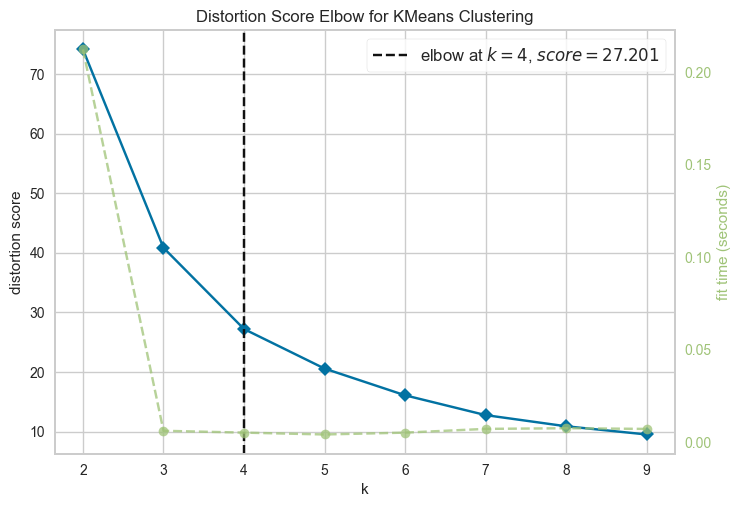

Optimal number of clusters: 4


In [39]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10))  # Search for optimal k from 2 to 10
visualizer.fit(scaled_rfm)

#Save the image below
plt.savefig("Elbow Graph.png",dpi = 300,bbox_inches ="tight")

visualizer.show()

print("Optimal number of clusters:", visualizer.elbow_value_)

#### Modeling

In [40]:
model_final = KMeans(n_clusters = visualizer.elbow_value_, random_state = 42)
labels = model_final.fit_predict(scaled_rfm)
labels

array([0, 0, 0, ..., 1, 1, 1])

#### Evaluate model

In [41]:
silhouette_avg = silhouette_score(scaled_rfm.iloc[:, :-1], labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.5722977577258531


#### Add Clusters to original Dataframe

In [42]:
rfm_df['Cluster'] = labels

rfm_df

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
14730,1,8,2005.06,0
14702,1,17,3292.14,0
12518,1,5,2056.89,0
17144,1,2,984.57,0
17405,1,3,1031.41,0
...,...,...,...,...
14729,374,1,313.49,1
17968,374,1,277.35,1
18074,374,1,489.60,1


## Cluster Distribution

In [43]:
# Count the occurrences of each cluster
cluster_counts = rfm_df['Cluster'].value_counts()
cluster_counts


Cluster
0    2119
2    1076
3     616
1     528
Name: count, dtype: int64

##### Plotting a pie chart

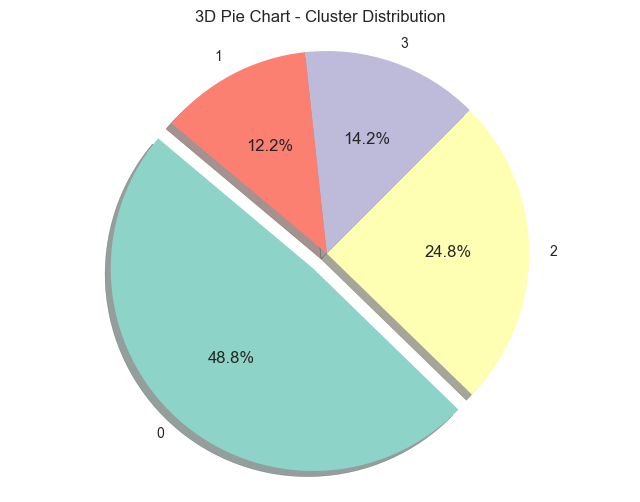

In [44]:
# Define custom colors based on the number of clusters
custom_colors = sns.color_palette('Set3', len(cluster_counts))

plt.figure(figsize=(8, 6))
explode = (0.1, 0, 0, 0)  # Explode first slice (optional for emphasis)

# Plot 3D pie chart with value counts as labels
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=custom_colors, explode=explode, shadow=True)

plt.title('3D Pie Chart - Cluster Distribution')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Save the image
plt.savefig("Pie_Chart_Clusters.png", dpi=300, bbox_inches="tight")

plt.show()

## Cluster Summary

In [45]:
# Calculate the mean R, F, and M scores for each cluster
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# Print the cluster summary
cluster_summary

,Cluster,Recency,Frequency,Monetary
0,0,19.022652,6.497876,3320.687933
1,1,305.373106,1.346591,553.571610
2,2,79.174721,2.682156,1046.628701
3,3,186.199675,1.899351,740.928378


#### Bar plot of summary

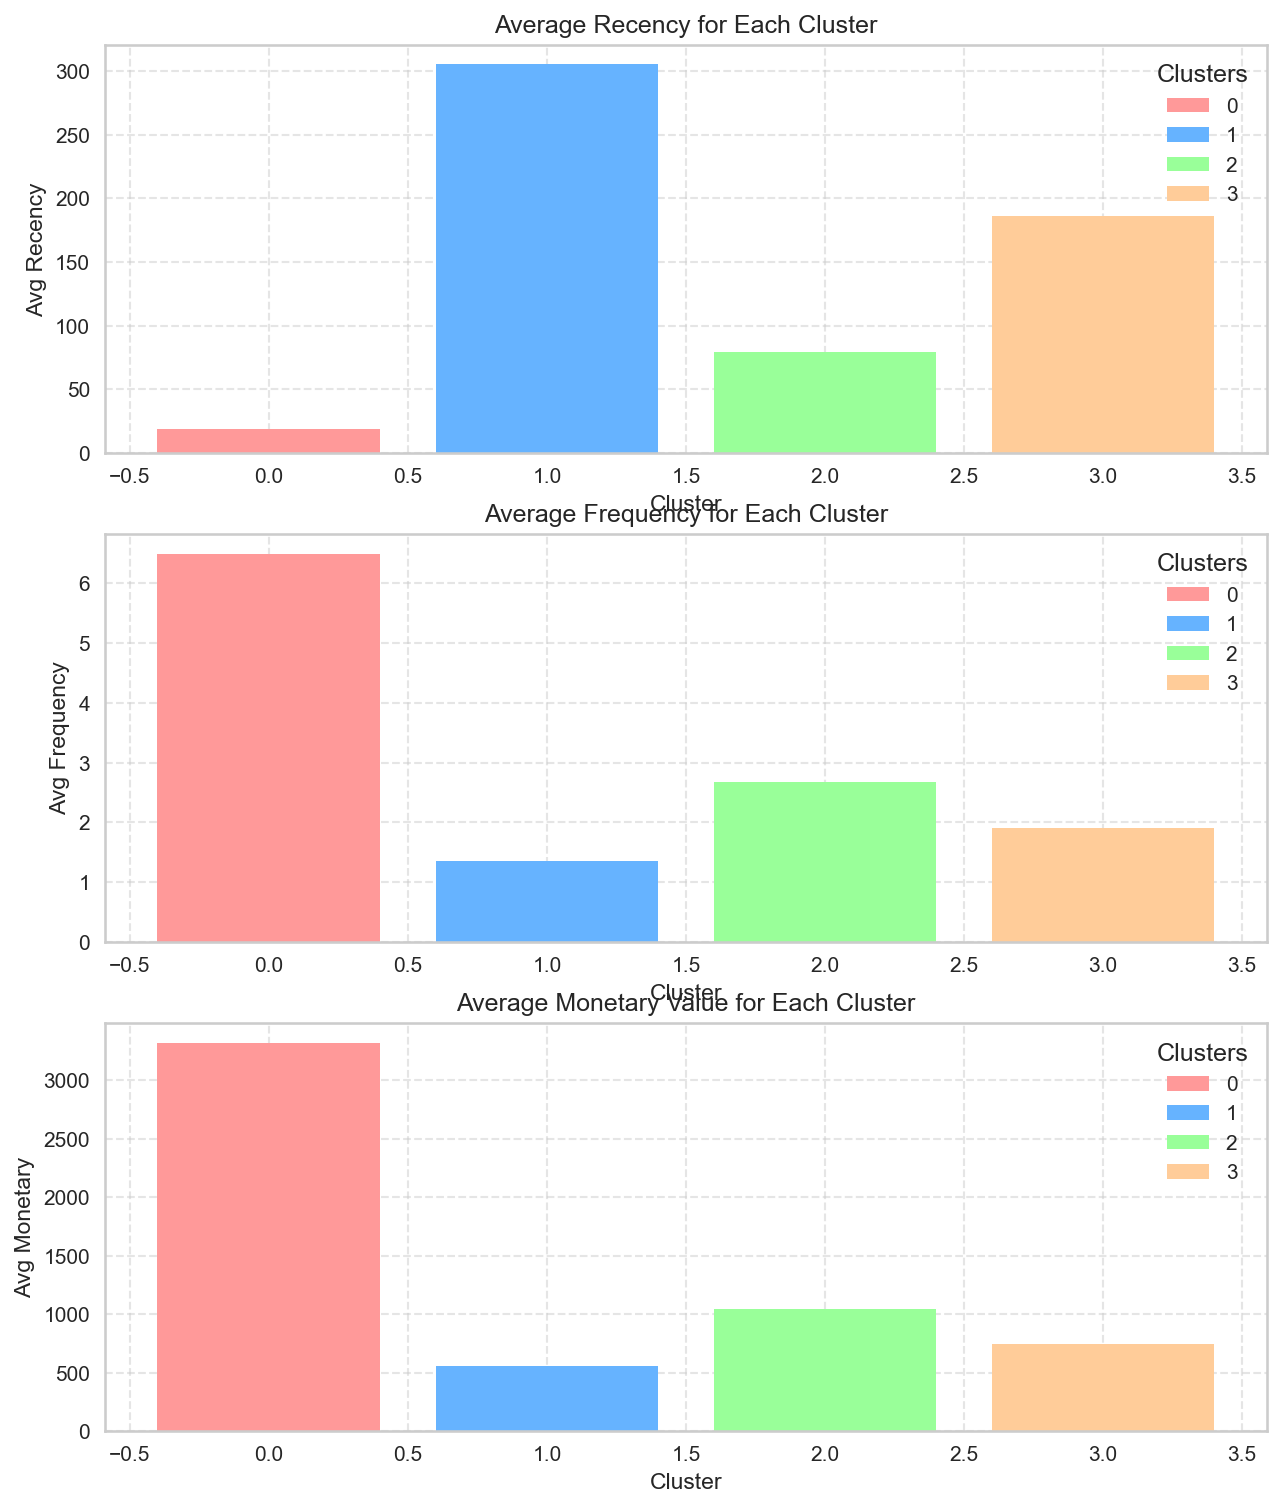

In [46]:
# To make it more insightful, we can plot these characteristics for better visualization
# Colors for each cluster
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0','#ffb3e6']

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 12), dpi=150)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary['Cluster'], cluster_summary['Recency'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary['Cluster'], title='Clusters') # Removed redundant legend

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary['Cluster'], cluster_summary['Frequency'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary['Cluster'], title='Clusters') # Removed redundant legend

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary['Cluster'], cluster_summary['Monetary'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary Value for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary['Cluster'], title='Clusters') # Removed redundant legend

# Save the image
plt.savefig("Average RFM (cluster).png", dpi=300, bbox_inches="tight")

plt.show()

**Average Recency for Each Cluster**

The first graph illustrates the average recency of customers across four clusters. Cluster 0, represented in red, has the lowest recency value, indicating that customers in this cluster made recent purchases more frequently than those in other clusters. Cluster 1, shown in blue, has the highest recency value, suggesting that customers in this group have not made a purchase in a long time. Cluster 2, depicted in green, and Cluster 3, in orange, have intermediate recency values, with Cluster 3's recency being higher than Cluster 2's. This graph helps identify which groups of customers are more active recently versus those who might be becoming inactive.


**Average Frequency for Each Cluster**

The second graph shows the average frequency of purchases for each cluster. Cluster 0 has the highest frequency, indicating that these customers are the most frequent purchasers. Cluster 1, conversely, has the lowest average frequency, suggesting these customers make purchases infrequently. Clusters 2 and 3 have moderate frequencies, with Cluster 2 having a slightly higher frequency than Cluster 3. This graph is crucial for understanding which customer groups are more engaged in terms of the number of transactions they make.


**Average Monetary Value for Each Cluster**

The third graph displays the average monetary value of purchases for each cluster. Cluster 0 stands out with the highest monetary value, indicating that these customers tend to spend the most money. Cluster 1 has the lowest average monetary value, showing that these customers contribute the least in terms of revenue. Clusters 2 and 3 fall in between, with Cluster 2 having a higher average monetary value than Cluster 3. This graph is essential for identifying the most valuable customers in terms of spending, which can help tailor marketing strategies to maximize revenue.

#### Radar chart of summary

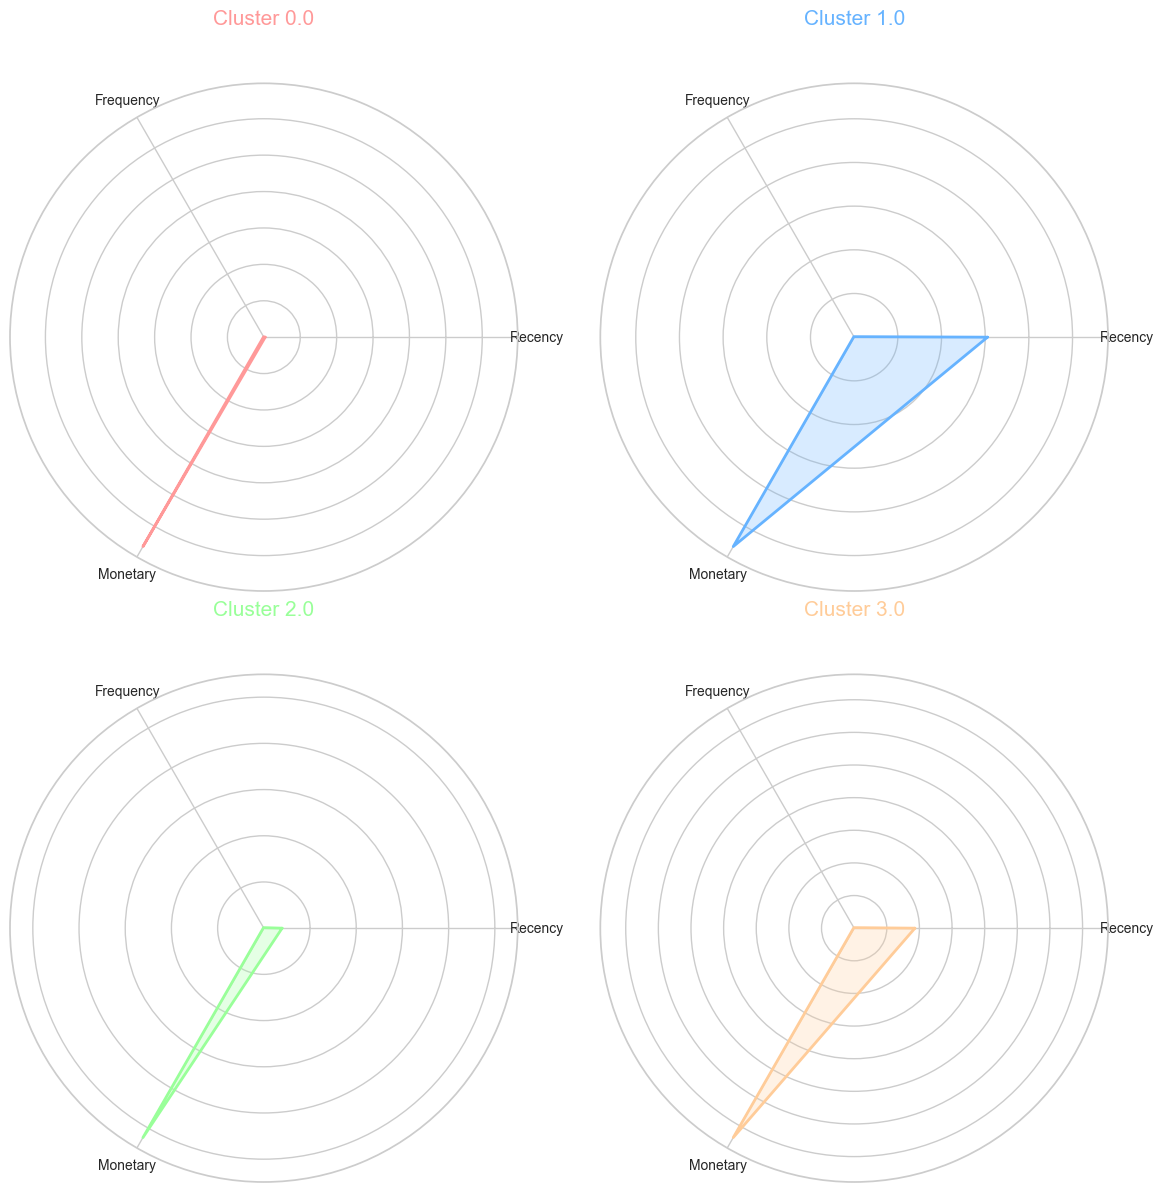

In [51]:
# Define the labels for the radar chart
labels = ['Recency', 'Frequency', 'Monetary']
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Make the plot circular by appending the start to the end
angles += angles[:1]

# Determine the grid size for subplots
n_clusters = len(cluster_summary)
rows = cols = int(np.ceil(np.sqrt(n_clusters)))

# Prepare the figure
fig, axes = plt.subplots(figsize=(12, 12), nrows=rows, ncols=cols, subplot_kw=dict(polar=True))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

# Plot radar charts for each cluster
for i, row in cluster_summary.iterrows():
    values = row[['Recency', 'Frequency', 'Monetary']].tolist()
    values += values[:1]  # Ensure the graph is circular

    ax = axes[i]
    ax.fill(angles, values, color=colors[i], alpha=0.25)
    ax.plot(angles, values, color=colors[i], linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(f'Cluster {row["Cluster"]}', size=15, color=colors[i], y=1.1)

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("Average_RFM_cluster_radar.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


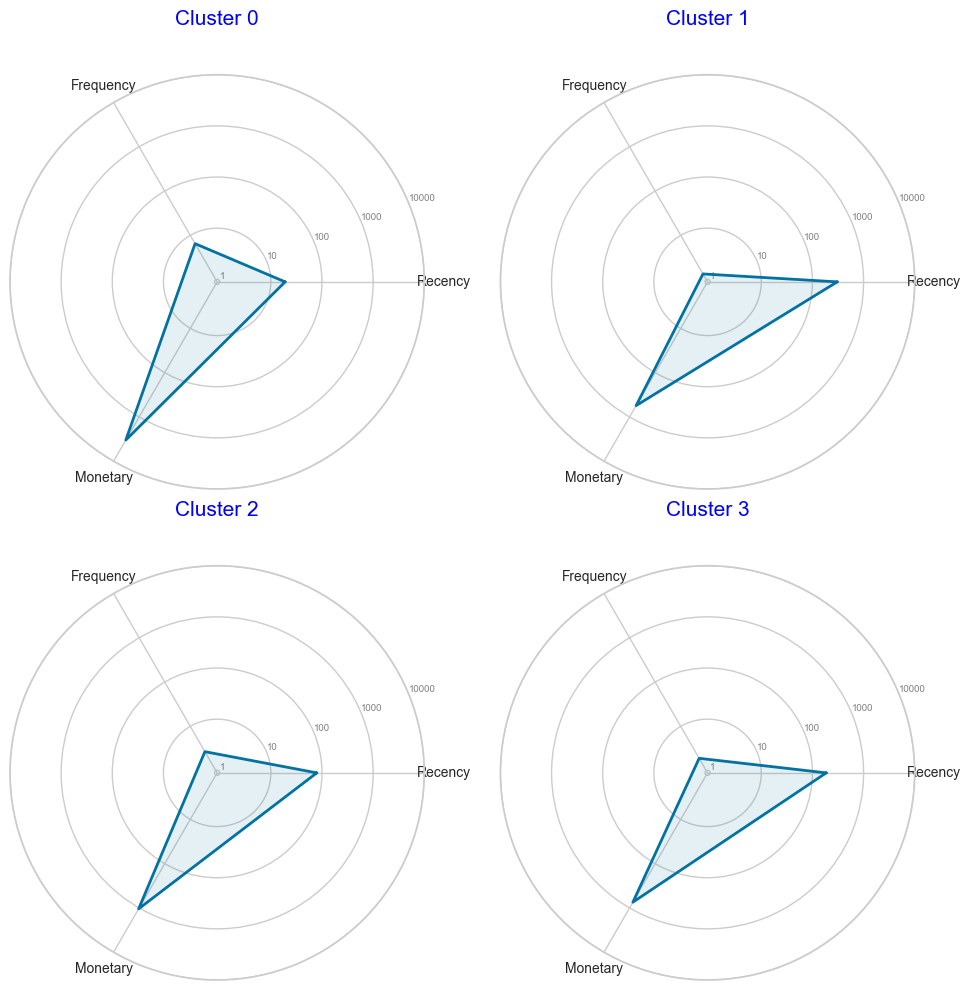

In [54]:
from math import pi

# Function to create a radar plot
def create_radar_plot(ax, df, cluster_idx):
    # Number of variables we're plotting
    categories = ['Recency', 'Frequency', 'Monetary']
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variables)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    
    # Draw one axe per variable and add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    
    # Draw ylabels
    ax.set_rscale('log')  # Set radial scale to logarithmic
    ax.set_yticks([1, 10, 100, 1000, 10000])
    ax.set_yticklabels(["1", "10", "100", "1000", "10000"], color="grey", size=7)
    ax.set_ylim(0, 10000)
    
    # Ind1 and ind2 values
    values = df.loc[cluster_idx].drop('Cluster').values.flatten().tolist()
    values += values[:1]
    
    # Plot data
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    
    # Title
    ax.set_title(f'Cluster {cluster_idx}', size=15, color='blue', y=1.1)

# Create a 2x2 grid for the radar plots
fig, axs = plt.subplots(2, 2, subplot_kw=dict(polar=True), figsize=(10, 10))

# Plot each cluster
for i in range(len(cluster_summary)):
    create_radar_plot(axs[i // 2, i % 2], cluster_summary, i)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


### Cluster 0
Cluster 0 exhibits a high frequency of transactions and high monetary value, indicating that customers in this cluster make frequent purchases and spend significantly. The recency is relatively low, suggesting these customers are highly engaged and have made recent purchases. This cluster represents the most valuable customers who are actively shopping and spending the most.

### Cluster 1
Cluster 1 is characterized by very high recency, low frequency, and low monetary value. This implies that customers in this cluster have not made purchases in a long time, buy infrequently, and spend relatively little. These customers might be at risk of churning and require re-engagement strategies to bring them back to active status.

### Cluster 2
Cluster 2 shows a moderate recency and frequency with a relatively higher monetary value than Cluster 1 but much lower than Cluster 0. These customers have made purchases somewhat recently and spend a moderate amount. They could represent a middle-tier segment that, with the right incentives, could be moved into the higher value category.

### Cluster 3
Cluster 3 displays high recency, low frequency, and moderate monetary value. This suggests these customers have made purchases more recently but do not shop frequently and spend a moderate amount when they do. They might be new or occasional customers who, with proper engagement, could be converted into more frequent buyers.

## Cluster Ranking and Names

Based on the summary provided, here are suggested names for each cluster based on typical interpretations in RFM (Recency, Frequency, Monetary) analysis:

1. **Cluster 0**:
   - **Name**: **"High-Value Customers"**
   - **Reasoning**: Cluster 0 has a relatively low recency (19.02 days), high frequency (6.50 times), and high monetary value (3320.69 units). This suggests active and valuable customers who make frequent purchases and spend significantly.


2. **Cluster 1**:
   - **Name**: **"Churned or Inactive Customers"**
   - **Reasoning**: Cluster 1 shows very high recency (305.37 days), very low frequency (1.35 times), and low monetary value (553.57 units). These characteristics indicate customers who haven't engaged recently, make infrequent purchases, and spend less, possibly indicating churn or inactivity.


3. **Cluster 2**:
   - **Name**: **"Regular Customers"**
   - **Reasoning**: Cluster 2 exhibits moderate recency (79.17 days), moderate frequency (2.68 times), and moderate monetary value (1046.63 units). This cluster likely represents customers who make purchases regularly without extreme behavior in either direction.


4. **Cluster 3**:
   - **Name**: **"Potential Loyal Customers"**
   - **Reasoning**: Cluster 3 has moderate recency (186.20 days), moderate frequency (1.90 times), and moderate monetary value (740.93 units). These customers show potential for becoming more loyal with targeted engagement strategies but are currently less engaged than Cluster 0.


These names are derived from the RFM metrics provided and aim to capture the typical behaviors and potential value each cluster represents to the business. Adjustments can be made based on additional context or specific business goals.

In [48]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Region,Sales_amount,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,Europe,15.30,Dec'2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34,Dec'2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,Europe,22.00,Dec'2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34,Dec'2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34,Dec'2010


In [49]:
# Merge df1 and df2 based on 'customer ID'
merged_df = pd.merge(df2, rfm_df[['Cluster']], left_on='CustomerID', right_index=True, how='left')


# If there are any unmatched 'customer ID's in df1, you might want to fill NaNs in 'Cluster' column
merged_df['Cluster'].fillna('Unknown', inplace=True)  # Replace 'Unknown' with whatever default value you want

# Now merged_df has a new column 'Cluster' with the values from df2 based on matching 'customer ID'
merged_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Region,Sales_amount,YearMonth,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,Europe,15.30,Dec'2010,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34,Dec'2010,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,Europe,22.00,Dec'2010,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34,Dec'2010,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Europe,20.34,Dec'2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,Europe,10.20,Dec'2011,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,Europe,12.60,Dec'2011,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,Europe,16.60,Dec'2011,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,Europe,16.60,Dec'2011,0
